# Team Assignment 2  
# HE 381

## Team Members  
1. Abhijeet Bhatta (25169)
2. Ankush Kumar (24033)
3. Chanyanka Kakati (27228) 
4. Suman Dafadar (24139)


## Question 1

In [1]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, transpile
from qiskit.quantum_info import Operator
from qiskit.circuit.library import StatePreparation, CPhaseGate, UnitaryGate, Initialize
from qiskit_aer import Aer, AerSimulator

import numpy as np
from math import sqrt
from numpy.linalg import norm
from matplotlib import pyplot as plt

In [2]:
r = lambda k: Operator([
    [1, 0,],
    [0, np.exp(2 * np.pi * 1j / 2**k)]
]) # R_k gate

def r_control(k):
    qc_r = QuantumCircuit(1)
    qc_r.unitary(r(k), [0])
    label_str = 'R_' + f'{k}'
    rk_control = qc_r.to_gate(label=f'${label_str}$').control(1)
    return rk_control # Controlled-R_k gate

In [3]:
delta = lambda epsilon: 1j * np.sqrt(1 - (1 - epsilon)**2)

U_noise = lambda epsilon: Operator([
    [1 - epsilon, delta(epsilon)],
    [delta(epsilon), 1 - epsilon]
]) # U_noise gate

def ur_control(k):
    qc_ur = QuantumCircuit(1)
    epsilon = np.random.uniform(0, 0.1)
    U = U_noise(epsilon)
    qc_ur.append(U, [0])
    qc_ur.append(r(k), [0])
    label_str = 'U_{noise}R_' + f'{k}'
    urk_control = qc_ur.to_gate(label=f'${label_str}$').control(1)
    return urk_control # Controlled-R_k gate

In [4]:
def qft(n, erroneous=False, careless=False, drawing=False):
    """
    Constructs a QFT circuit which can have erroneous or careless behaviour based on the flag.
    """
    qc = QuantumCircuit(n, name='QFT (reversed)')
        
    # Apply Hadamards and Rotation gates
    for i in reversed(range(n)):
        qc.h(i)
        for j in reversed(range(i)):
            k = i - j + 1
            if erroneous and (i - j + 1 == 3):
                qc.append(r_control(2), [j, i])
            elif careless and (i - j + 1 == 3): 
                qc.append(ur_control(k), [j, i])
            else:
                qc.append(r_control(k), [j, i])
        if drawing: qc.barrier()

    # Apply SWAPs
    for i in range(n//2):
        qc.swap(i, (n-1)-i)
    if drawing: qc.barrier()
    
    return qc

### Q1.1

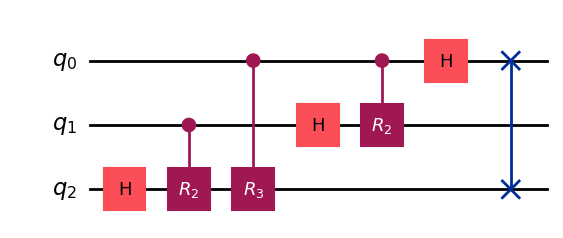

In [5]:
qft(n=3, erroneous=False, careless=False, drawing=True).draw('mpl', plot_barriers=False)

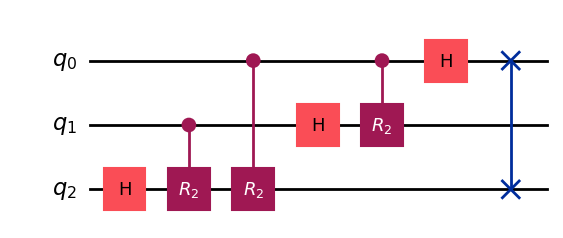

In [6]:
qft(n=3, erroneous=True, careless=False, drawing=True).draw('mpl', plot_barriers=False)

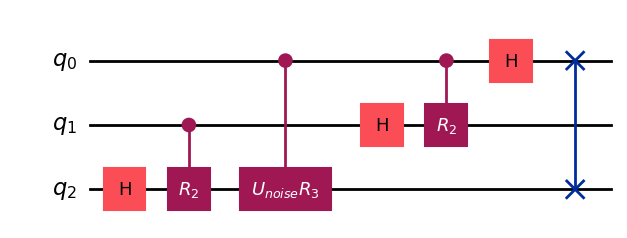

In [7]:
qft(n=3, erroneous=False, careless=True, drawing=True).draw('mpl', plot_barriers=False)

In [8]:
def hadamard_test(j: int, inp: int, psi: np.ndarray, U: QuantumCircuit, imag=False):
    """
    Constructs a Hadamard test circuit to measure the real or imaginary part of <j|U|psi>.
    """
    anc_reg = QuantumRegister(1, "ancilla")
    inp_reg = QuantumRegister(inp, "sys")
    c_reg   = ClassicalRegister(1, "c")
    qc = QuantumCircuit(anc_reg, inp_reg, c_reg)

    qc.h(anc_reg[0])

    U_tilde = QuantumCircuit(inp)
    U_tilde.append(StatePreparation(psi), range(inp))
    U_tilde.append(U.to_gate(), range(inp))
    for k in range(inp):
        if (j >> k) & 1:
            U_tilde.x(k)
    U_tilde_gate = U_tilde.to_gate(label="U_tilde")

    qc.append(U_tilde_gate.control(), [anc_reg[0]] + list(inp_reg))

    # For the imaginary part, apply an S-dagger gate to the ancilla
    if imag:
        qc.sdg(anc_reg[0])
    qc.h(anc_reg[0])

    # Measure the ancilla
    qc.measure(anc_reg, c_reg)
    return qc

In [9]:
def prob0_with_error(qc, shots=1_000):
    """
    Executes a circuit and returns the probability of measuring '0'
    along with its standard error.
    """
    simulator = AerSimulator()
    transpiled_qc = transpile(qc, simulator)
    result = simulator.run(transpiled_qc, shots=shots).result()
    counts = result.get_counts(transpiled_qc)
    p0 = counts.get('0', 0) / shots
    # Standard error for binomial distribution
    err = np.sqrt(p0 * (1 - p0) / shots)
    return p0, err

def part_with_error(qc, shots=1_000):
    """
    Returns the estimated expectation value (real or imag) and its error bar.
    """
    p0, err_p0 = prob0_with_error(qc, shots=shots)
    value = 2 * p0 - 1
    error = 2 * err_p0
    return value, error


### Q1.2

In [10]:
# -------- 1) Erroneous QFT (same as before, but standalone) --------
def qft_custom_err(n):
    qc = QuantumCircuit(n, name=f"QFT_err_n{n}")
    for j in range(n):
        qc.h(j)
        max_k = n - j
        for k in range(2, max_k + 1):
            control = j + k - 1
            target = j
            ideal_angle = np.pi / (2 ** (k - 1))
            if k == 3:  # replace R3 with R2
                angle = np.pi / (2 ** (2 - 1))  # pi/2
            else:
                angle = ideal_angle
            qc.append(CPhaseGate(angle), [control, target])
    # final swaps
    for i in range(n // 2):
        qc.swap(i, n - i - 1)
    return qc

# -------- 2) Build normalized input vector v' --------
v = np.array([1, 1j, 2.5, 4+1j, 5, 7], dtype=complex)
vprime = np.concatenate([v, np.zeros(2, dtype=complex)])  # pad to 8
Nnorm = np.sum(np.abs(vprime)**2)
alpha = vprime / np.sqrt(Nnorm)  # normalized input

# -------- 3) Apply U_err to input --------
n = 3
qc_err = qft_custom_err(n)
U_err = Operator(qc_err).data  # full 8x8 matrix
out_state = U_err.dot(alpha)

# -------- 4) Extract exact overlaps --------
results_exact = []
for j in range(2**n):
    val = out_state[j]
    results_exact.append((j, val.real, val.imag))

# Print neatly
print(" j |   Exact Re   |   Exact Im")
print("---+--------------+--------------")
for j, re, im in results_exact:
    print(f"{j:2d} | {re: .6f}   | {im: .6f}")


 j |   Exact Re   |   Exact Im
---+--------------+--------------
 0 |  0.692029   |  0.070977
 1 | -0.159699   |  0.070977
 2 | -0.195188   |  0.425864
 3 | -0.195188   | -0.425864
 4 |  0.070977   | -0.159699
 5 |  0.070977   | -0.017744
 6 |  0.070977   |  0.017744
 7 | -0.070977   |  0.017744


U_err shape: (8, 8)
Controlled U shape: (16, 16)


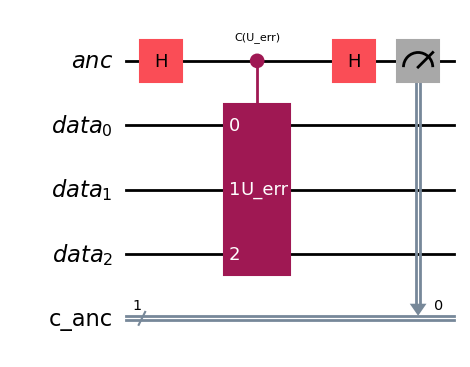

In [11]:
def qft_custom_err(n):
    qc = QuantumCircuit(n, name=f"QFT_err_n{n}")
    for j in range(n):
        qc.h(j)
        max_k = n - j
        for k in range(2, max_k + 1):
            control = j + k - 1
            target = j
            ideal_angle = np.pi / (2 ** (k - 1))
            if k == 3:
                angle = np.pi / (2 ** 1)
                label = "R2(err)"
            else:
                angle = ideal_angle
                label = f"R{k}"
            gate = CPhaseGate(angle)
            gate.label = label
            qc.append(gate, [control, target])
        # remove qc.barrier() !
    for i in range(n // 2):
        qc.swap(i, n - i - 1)
    return qc

# --- parameters ---
n = 3

# Build the erroneous QFT circuit (acting on `n` data qubits)
qc_data = qft_custom_err(n)        # this is a QuantumCircuit on n qubits
qc_data.draw('mpl')               # (optional) textual view

# Convert the data-circuit into a Gate (so it can be appended as a single unit)
U_err = qc_data.to_gate(label="U_err")

# Build the controlled-U: single ancilla control (1 control qubit)
# Note: .control(1) produces a gate that expects control qubit(s) followed by the original target qubits
U_err_ctrl = U_err.control(1, label="C(U_err)")

# Inspect unitary matrices (optional; works for small n)
# Full unitary of U_err:
mat_U_err = Operator(qc_data).data
print("U_err shape:", mat_U_err.shape)

# Full unitary of controlled-U (2^1 * 2^n by same)
# We can build a small circuit containing the controlled gate and ask Operator for its matrix:
qc_temp = QuantumCircuit(1 + n)  # 1 control + n data qubits
qc_temp.append(U_err_ctrl, qc_temp.qubits)   # append expects the control qubit first, then data qubits
mat_CU = Operator(qc_temp).data
print("Controlled U shape:", mat_CU.shape)

# --- Example: place controlled-U into a Hadamard-test-style circuit ---
# ancilla q0 will be the control, data qubits q1..qn will hold the input state |v'>
anc = QuantumRegister(1, 'anc')
data = QuantumRegister(n, 'data')
creg = ClassicalRegister(1, 'c_anc')
had_test = QuantumCircuit(anc, data, creg, name="Hadamard_test_example")

# Prepare ancilla in |+>:
had_test.h(anc[0])

# (Optional) prepare some example data state on `data` register.
# For demo: prepare computational basis |0...0> (do nothing), or you could append an initialize gate.

# Append controlled-U: controlled gate expects (control, data0, data1, ..., data_{n-1})
# Qiskit ordering when appending: pass the qubits in the same order as the gate's definition:
had_test.append(U_err_ctrl, [anc[0]] + data[:] )

# Finish Hadamard-test: H on ancilla then measure ancilla
had_test.h(anc[0])
had_test.measure(anc[0], creg[0])

# Draw final hadamard-test circuit
had_test.draw('mpl')

# If you want to run the Hadamard test on a simulator:
# from qiskit import Aer, transpile, assemble
# backend = Aer.get_backend('aer_simulator')
# t_qc = transpile(had_test, backend)
# qobj = assemble(t_qc, shots=2000)
# result = backend.run(qobj).result()
# print(result.get_counts())


In [12]:
# --- Main Script ---
n = 3
N = 2**n

# Define the input vector and normalize it
input_vec = np.array([1, 1j, 2.5, 4+1j, 5, 7, 0, 0])
normalized_input_vec = input_vec / np.linalg.norm(input_vec)

dft_val = np.fft.ifft(normalized_input_vec) * np.sqrt(N)

qft_op = qft(n=n, erroneous=True)

shots = 1_000
for j in range(N):
    # Real part
    real_part, real_err = part_with_error(hadamard_test(j, n, normalized_input_vec, qft_op), shots=shots)
    # Imag part
    imag_part, imag_err = part_with_error(hadamard_test(j, n, normalized_input_vec, qft_op, imag=True), shots=shots)
    
    # Print results with error bars
    print(f'j={j}:')
    print(f'  Erroneous QFT: {real_part: .4f}{imag_part:+.4f}j ± {real_err:.4f}{imag_err:+.4f}j')
    print(f'  DFT          : {dft_val[j].real: .4f}{dft_val[j].imag:+.4f}j\n')

j=0:
  Erroneous QFT:  0.6820+0.0700j ± 0.0231+0.0315j
  DFT          :  0.6920+0.0710j

j=1:
  Erroneous QFT: -0.2860-0.1880j ± 0.0303+0.0311j
  DFT          : -0.4682+0.0134j

j=2:
  Erroneous QFT:  0.1360+0.0400j ± 0.0313+0.0316j
  DFT          :  0.1242+0.1065j

j=3:
  Erroneous QFT:  0.0700-0.0280j ± 0.0315+0.0316j
  DFT          :  0.0839-0.1640j

j=4:
  Erroneous QFT: -0.0800-0.0820j ± 0.0315+0.0315j
  DFT          : -0.0887-0.0710j

j=5:
  Erroneous QFT:  0.0220+0.3400j ± 0.0316+0.0297j
  DFT          :  0.1843+0.1640j

j=6:
  Erroneous QFT:  0.1300-0.1320j ± 0.0314+0.0313j
  DFT          :  0.1242-0.1065j

j=7:
  Erroneous QFT: -0.3300-0.2080j ± 0.0299+0.0309j
  DFT          : -0.3678-0.0134j



U_err shape: (8, 8)
Normalization factor N = 99.25

Raw counts (Real circuit): {'1011': 372, '0011': 22, '1010': 602, '0001': 358, '0111': 623, '0101': 393, '1000': 327, '0110': 173, '0000': 638, '0100': 201, '1001': 218, '0010': 57, '1100': 3, '1110': 7, '1101': 4, '1111': 2}
Raw counts (Imag circuit): {'0001': 492, '1001': 438, '1010': 519, '0111': 704, '1011': 506, '0000': 477, '1000': 132, '0101': 57, '0100': 496, '0110': 78, '1111': 10, '0010': 62, '0011': 10, '1101': 5, '1100': 8, '1110': 6}

--- Results for j=5 ---
Real part: postselected runs = 974 N0= 602 N1= 372
Estimate Re = 0.236140 ± 0.015568

Imag part: postselected runs = 1025 N0= 519 N1= 506
Estimate Im = 0.012683 ± 0.015616


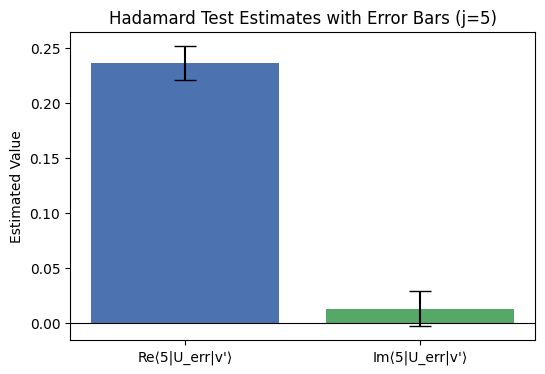

In [13]:
def qft_custom_err(n):
    qc = QuantumCircuit(n, name=f"QFT_err_n{n}")
    for j in range(n):
        qc.h(j)
        max_k = n - j
        for k in range(2, max_k + 1):
            control = j + k - 1
            target = j
            ideal_angle = np.pi / (2 ** (k - 1))
            if k == 3:
                angle = np.pi / (2 ** 1)
                label = "R2(err)"
            else:
                angle = ideal_angle
                label = f"R{k}"
            gate = CPhaseGate(angle)
            gate.label = label
            qc.append(gate, [control, target])
    for i in range(n // 2):
        qc.swap(i, n - i - 1)
    return qc

# -----------------------
# 2) Hadamard-test builder + postprocess (same logic as provided earlier)
# -----------------------
def build_hadamard_test_postselect(n, U_err_ctrl, state_prep_gate=None,
                                   j=0, measure_imag=False,
                                   name="Hadamard_test_post"):
    """
    Single-ancilla hadamard-test circuit that measures ancilla and all data qubits.
    Uses a single ClassicalRegister of size 1+n where:
      - c[0] assigned to ancilla measurement
      - c[1+i] assigned to data[i] measurement
    (We will parse counts accordingly below.)
    """
    anc = QuantumRegister(1, 'anc')
    data = QuantumRegister(n, 'data')
    creg = ClassicalRegister(1 + n, 'c')   # c[0] -> anc, c[1..n] -> data
    qc = QuantumCircuit(anc, data, creg, name=name)

    qc.h(anc[0])  # ancilla -> |+>
    if state_prep_gate is not None:
        qc.append(state_prep_gate, data[:])   # prepare |v'>

    # Append controlled-U (expects [control, data0, data1, ...])
    qc.append(U_err_ctrl, [anc[0]] + data[:])

    if measure_imag:
        qc.sdg(anc[0])
    qc.h(anc[0])

    # Measure ancilla into c[0], data[i] into c[1+i]
    qc.measure(anc[0], creg[0])
    for i in range(n):
        qc.measure(data[i], creg[1 + i])

    return qc

def postselect_result_to_estimate(counts, j, n):
    """
    Parse counts returned by Qiskit where classical register 'c' has length 1+n.
    Qiskit's bitstring format: leftmost char = highest index classical bit (index 1+n-1),
    rightmost char = classical bit index 0. We created c[0]..c[n] so:
      - ancilla bit is at RIGHTMOST position (index 0) -> anc_bit = bitstr[-1]
      - data bits occupy left positions: bitstr[0 : n] correspond to c[n]..c[1]
        We want to reassemble them into a string matching format(j, f'0{n}b') which is MSB..LSB.
    """
    total_bits = 1 + n
    bin_j = format(j, f'0{n}b')  # e.g. '101'
    N0 = N1 = N_post = 0

    for bitstr, cnt in counts.items():
        if len(bitstr) < total_bits:
            bitstr = bitstr.zfill(total_bits)
        anc_bit = bitstr[-1]                 # rightmost -> c[0]
        data_bits_reversed_order = bitstr[:-1]  # left part corresponds to c[n]..c[1]
        # data_bits_reversed_order currently has c[n] (leftmost) ... c[1] (rightmost).
        # That matches binary MSB..LSB ordering for the data qubits if data[0] was stored in c[1].
        data_bits = data_bits_reversed_order  # treat as MSB..LSB
        if data_bits == bin_j:
            N_post += cnt
            if anc_bit == '0':
                N0 += cnt
            else:
                N1 += cnt

    if N_post == 0:
        return (0, 0, 0, None, None)
    est = (N0 - N1) / (N0 + N1)
    p = N0 / (N0 + N1)
    stderr = sqrt(p * (1 - p) / (N0 + N1))
    return (N_post, N0, N1, est, stderr)

# -----------------------
# 3) Put everything together and run
# -----------------------
if __name__ == "__main__":
    n = 3
    # Build U_err and its controlled version (these are created fresh here)
    qc_data = qft_custom_err(n)
    U_err = qc_data.to_gate(label="U_err")
    U_err_ctrl = U_err.control(1, label="C(U_err)")

    # Optional: inspect matrix shapes (small n only)
    mat_U_err = Operator(qc_data).data
    print("U_err shape:", mat_U_err.shape)

    # Prepare v'
    vprime = np.array([1, 1j, 2.5, 4+1j, 5, 7, 0, 0], dtype=complex)
    Nnorm = np.sum(np.abs(vprime)**2)
    alpha = vprime / np.sqrt(Nnorm)
    print("Normalization factor N =", Nnorm)

    init_gate = Initialize(alpha)

    # Build Hadamard test circuits (for a chosen j)
    j = 5
    qc_real = build_hadamard_test_postselect(n, U_err_ctrl, state_prep_gate=init_gate,
                                             j=j, measure_imag=False, name="Had_Test_Re")
    qc_imag = build_hadamard_test_postselect(n, U_err_ctrl, state_prep_gate=init_gate,
                                             j=j, measure_imag=True, name="Had_Test_Im")

    # Run on Aer
    backend = Aer.get_backend('aer_simulator')
    shots = 4000
    job_re = backend.run(transpile(qc_real, backend), shots=shots)
    job_im = backend.run(transpile(qc_imag, backend), shots=shots)
    counts_re = job_re.result().get_counts()
    counts_im = job_im.result().get_counts()

    # Print raw counts to help debug bit-ordering if needed
    print("\nRaw counts (Real circuit):", counts_re)
    print("Raw counts (Imag circuit):", counts_im)

    # Postselect and estimate
    Npost_r, N0_r, N1_r, est_re, stderr_re = postselect_result_to_estimate(counts_re, j=j, n=n)
    Npost_i, N0_i, N1_i, est_im, stderr_im = postselect_result_to_estimate(counts_im, j=j, n=n)

    print("\n--- Results for j={} ---".format(j))
    print("Real part: postselected runs =", Npost_r, "N0=", N0_r, "N1=", N1_r)
    if Npost_r > 0:
        print("Estimate Re = {:.6f} ± {:.6f}".format(est_re, stderr_re))
    else:
        print("No postselected runs for Re (increase shots or pick different j).")

    print("\nImag part: postselected runs =", Npost_i, "N0=", N0_i, "N1=", N1_i)
    if Npost_i > 0:
        print("Estimate Im = {:.6f} ± {:.6f}".format(est_im, stderr_im))
    else:
        print("No postselected runs for Im (increase shots or pick different j).")



# Collect estimates and errors from above
labels = [f"Re⟨{j}|U_err|v'⟩", f"Im⟨{j}|U_err|v'⟩"]
values = [est_re if est_re is not None else 0,
          est_im if est_im is not None else 0]
errors = [stderr_re if stderr_re is not None else 0,
          stderr_im if stderr_im is not None else 0]

plt.figure(figsize=(6,4))
bars = plt.bar(labels, values, yerr=errors, capsize=8, color=["#4C72B0","#55A868"])
plt.axhline(0, color="black", linewidth=0.8)
plt.ylabel("Estimated Value")
plt.title(f"Hadamard Test Estimates with Error Bars (j={j})")
plt.show()


j=0: Re=-0.704750 ± 0.007932 (N0=1181,N1=6819)  Im=-0.065750 ± 0.011156 (N0=3737,N1=4263)  Exact=(0.692029+0.070977j)
j=1: Re=0.156000 ± 0.011043 (N0=4624,N1=3376)  Im=-0.086750 ± 0.011138 (N0=3653,N1=4347)  Exact=(-0.159699+0.070977j)
j=2: Re=0.219750 ± 0.010907 (N0=4879,N1=3121)  Im=-0.414250 ± 0.010176 (N0=2343,N1=5657)  Exact=(-0.195188+0.425864j)
j=3: Re=0.194250 ± 0.010967 (N0=4777,N1=3223)  Im=0.422500 ± 0.010133 (N0=5690,N1=2310)  Exact=(-0.195188+-0.425864j)
j=4: Re=-0.079250 ± 0.011145 (N0=3683,N1=4317)  Im=0.155500 ± 0.011044 (N0=4622,N1=3378)  Exact=(0.070977+-0.159699j)
j=5: Re=-0.071250 ± 0.011152 (N0=3715,N1=4285)  Im=-0.004500 ± 0.011180 (N0=3982,N1=4018)  Exact=(0.070977+-0.017744j)
j=6: Re=-0.058750 ± 0.011161 (N0=3765,N1=4235)  Im=-0.040750 ± 0.011171 (N0=3837,N1=4163)  Exact=(0.070977+0.017744j)
j=7: Re=0.058750 ± 0.011161 (N0=4235,N1=3765)  Im=-0.018500 ± 0.011178 (N0=3926,N1=4074)  Exact=(-0.070977+0.017744j)

Summary table (estimated ± stderr) vs exact overlap:
 

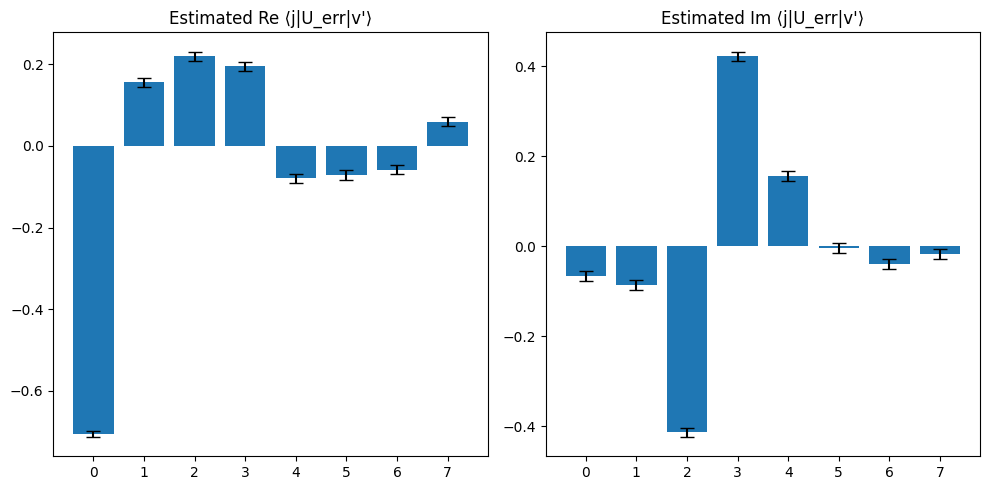

In [14]:
# ---------- 1) erroneous QFT: every R3 replaced by R2 ----------
def qft_custom_err(n):
    qc = QuantumCircuit(n, name=f"QFT_err_n{n}")
    for j in range(n):
        qc.h(j)
        max_k = n - j
        for k in range(2, max_k + 1):
            control = j + k - 1
            target = j
            ideal_angle = np.pi / (2 ** (k - 1))
            if k == 3:
                angle = np.pi / (2 ** (2 - 1))  # R2 angle = pi/2 (error inserted)
            else:
                angle = ideal_angle
            gate = CPhaseGate(angle)
            qc.append(gate, [control, target])
    for i in range(n // 2):
        qc.swap(i, n - i - 1)
    return qc

# ---------- 2) utilities: build unitary with first column = alpha ----------
def build_unitary_from_state(alpha):
    dim = alpha.shape[0]
    U = np.zeros((dim, dim), dtype=complex)
    U[:, 0] = alpha
    col_idx = 1
    while col_idx < dim:
        v = (np.random.randn(dim) + 1j * np.random.randn(dim))
        for k in range(col_idx):
            proj = np.vdot(U[:, k], v)
            v = v - proj * U[:, k]
        vnorm = norm(v)
        if vnorm < 1e-12:
            continue
        U[:, col_idx] = v / vnorm
        col_idx += 1
    # numeric orthonormalization fix
    Q, _ = np.linalg.qr(U)
    return Q

def build_permutation_unitary_mapping_zero_to_j(dim, j):
    P = np.zeros((dim, dim), dtype=complex)
    P[j, 0] = 1.0
    col = 1
    for idx in range(dim):
        if idx == j:
            continue
        P[idx, col] = 1.0
        col += 1
    return P

# ---------- 3) controlled-stateprep hadamard using UnitaryGate ----------
def build_controlled_stateprep_hadamard_using_unitary(n, U_err_ctrl, alpha, j=0, measure_imag=False, name="HadCtrl_unitary"):
    anc = QuantumRegister(1, 'anc')
    data = QuantumRegister(n, 'data')
    creg = ClassicalRegister(1, 'c')   # single classical bit for ancilla
    qc = QuantumCircuit(anc, data, creg, name=name)

    qc.h(anc[0])

    dim = 2**n

    # Controlled map |0> -> |j> when anc=0. Convert to control-on-1 with X.
    P = build_permutation_unitary_mapping_zero_to_j(dim, j)
    P_gate = UnitaryGate(P, label=f"P_map0to{j}")
    P_ctrl = P_gate.control(1, label=f"C(P_map0to{j})")
    qc.x(anc[0])                 # transform control-on-0 to control-on-1
    qc.append(P_ctrl, [anc[0]] + data[:])
    qc.x(anc[0])

    # Controlled prepare |v'> when anc=1: U_prep whose first column is alpha
    U_prep = build_unitary_from_state(alpha)
    U_prep_gate = UnitaryGate(U_prep, label="U_prep_vprime")
    U_prep_ctrl = U_prep_gate.control(1, label="C(U_prep_vprime)")
    qc.append(U_prep_ctrl, [anc[0]] + data[:])

    # Append controlled U_err (anc as control) to map |v'> -> U_err|v'> when anc=1
    qc.append(U_err_ctrl, [anc[0]] + data[:])

    # measure ancilla in X-basis (real) or Y-basis (imag)
    if measure_imag:
        qc.sdg(anc[0])
    qc.h(anc[0])
    qc.measure(anc[0], creg[0])

    return qc

# ---------- 4) ancilla expectation helper ----------
def ancilla_expectation_from_counts(counts):
    N0 = counts.get('0', 0)
    N1 = counts.get('1', 0)
    if N0 + N1 == 0:
        for k, v in counts.items():
            if k[-1] == '0':
                N0 += v
            elif k[-1] == '1':
                N1 += v
    total = N0 + N1
    if total == 0:
        return None, N0, N1, 0.0
    E = (N0 - N1) / total
    p = N0 / total
    stderr = 2 * sqrt(p * (1 - p) / total)
    return E, N0, N1, stderr

# ---------- 5) main: run for all j and report ----------
def run_all_j(n=3, shots=8000, seed_transpiler=123):
    qc_data = qft_custom_err(n)
    U_err = qc_data.to_gate(label="U_err")
    U_err_ctrl = U_err.control(1, label="C(U_err)")

    v = np.array([1, 1j, 2.5, 4+1j, 5, 7], dtype=complex)
    vprime = np.concatenate([v, np.zeros(2, dtype=complex)])  # pad to 8
    Nnorm = np.sum(np.abs(vprime)**2)
    alpha = vprime / np.sqrt(Nnorm)
    dim = 2**n

    U_err_full = Operator(qc_data).data
    results = []
    backend = Aer.get_backend('aer_simulator')

    for j in range(dim):
        qc_re = build_controlled_stateprep_hadamard_using_unitary(n, U_err_ctrl, alpha, j=j, measure_imag=False, name=f"HadCtrl_Re_j{j}")
        qc_im = build_controlled_stateprep_hadamard_using_unitary(n, U_err_ctrl, alpha, j=j, measure_imag=True,  name=f"HadCtrl_Im_j{j}")

        # Transpile: Qiskit 2.2.0 expects seed_transpiler; some installs accept both.
        try:
            t_re = transpile(qc_re, backend, seed_transpiler=seed_transpiler)
            t_im = transpile(qc_im, backend, seed_transpiler=seed_transpiler + 1)
        except TypeError:
            # fallback: call without seed keyword (robust)
            t_re = transpile(qc_re, backend)
            t_im = transpile(qc_im, backend)

        job_re = backend.run(t_re, shots=shots)
        job_im = backend.run(t_im, shots=shots)
        counts_re = job_re.result().get_counts()
        counts_im = job_im.result().get_counts()

        E_re, N0_re, N1_re, stderr_re = ancilla_expectation_from_counts(counts_re)
        E_im, N0_im, N1_im, stderr_im = ancilla_expectation_from_counts(counts_im)
        exact = np.vdot(np.eye(dim)[j], U_err_full.dot(alpha))

        results.append({
            'j': j,
            'E_re': E_re, 'SE_re': stderr_re, 'N0_re': N0_re, 'N1_re': N1_re,
            'E_im': E_im, 'SE_im': stderr_im, 'N0_im': N0_im, 'N1_im': N1_im,
            'exact': exact
        })

        print(f"j={j}: Re={E_re:.6f} ± {stderr_re:.6f} (N0={N0_re},N1={N1_re})  "
              f"Im={E_im:.6f} ± {stderr_im:.6f} (N0={N0_im},N1={N1_im})  "
              f"Exact=({exact.real:.6f}+{exact.imag:.6f}j)")
    return results

if __name__ == "__main__":
    n = 3
    shots = 8000
    results = run_all_j(n=n, shots=shots)

    # tabulate and plot
    js = [r['j'] for r in results]
    re_vals = [r['E_re'] for r in results]
    im_vals = [r['E_im'] for r in results]
    se_re = [r['SE_re'] for r in results]
    se_im = [r['SE_im'] for r in results]
    exact = [r['exact'] for r in results]

    print("\nSummary table (estimated ± stderr) vs exact overlap:")
    print(" j |    Re_est ± SE    |    Im_est ± SE    | exact (Re, Im) ")
    print("---+-------------------+-------------------+-----------------")
    for idx in range(len(js)):
        j = js[idx]
        print(f"{j:2d} | {re_vals[idx]: .6f} ± {se_re[idx]: .6f} | {im_vals[idx]: .6f} ± {se_im[idx]: .6f} | ({exact[idx].real: .6f}, {exact[idx].imag: .6f})")

    # plot
    x = np.arange(len(js))
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.bar(x, re_vals, yerr=se_re, capsize=5)
    plt.xticks(x, [str(j) for j in js])
    plt.title("Estimated Re ⟨j|U_err|v'⟩")
    plt.subplot(1,2,2)
    plt.bar(x, im_vals, yerr=se_im, capsize=5)
    plt.xticks(x, [str(j) for j in js])
    plt.title("Estimated Im ⟨j|U_err|v'⟩")
    plt.tight_layout()
    plt.show()

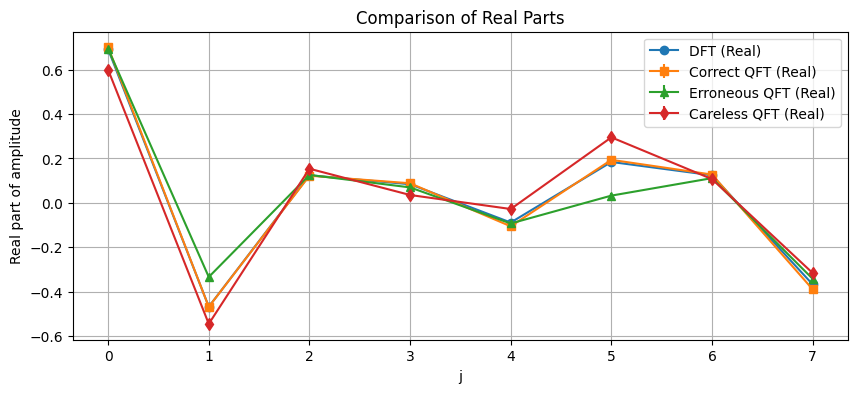

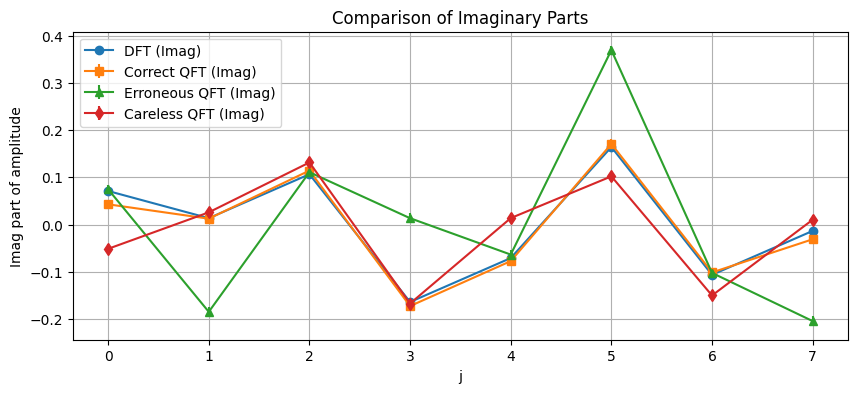

In [15]:
shots = 10_000

# Arrays to store results
real_correct, imag_correct, real_correct_err, imag_correct_err = [], [], [], []
real_error, imag_error, real_error_err, imag_error_err = [], [], [], []
real_careless, imag_careless, real_careless_err, imag_careless_err = [], [], [], []

for j in range(N):
    # Correct QFT (erroneous=False, careless=False)
    r_c, r_c_err = part_with_error(hadamard_test(j, n, normalized_input_vec, qft(n=n, erroneous=False, careless=False)), shots=shots)
    i_c, i_c_err = part_with_error(hadamard_test(j, n, normalized_input_vec, qft(n=n, erroneous=False, careless=False), imag=True), shots=shots)
    real_correct.append(r_c);   real_correct_err.append(r_c_err)
    imag_correct.append(i_c);   imag_correct_err.append(i_c_err)

    # Erroneous QFT (erroneous=True)
    r_e, r_e_err = part_with_error(hadamard_test(j, n, normalized_input_vec, qft(n=n, erroneous=True, careless=False)), shots=shots)
    i_e, i_e_err = part_with_error(hadamard_test(j, n, normalized_input_vec, qft(n=n, erroneous=True, careless=False), imag=True), shots=shots)
    real_error.append(r_e);     real_error_err.append(r_e_err)
    imag_error.append(i_e);     imag_error_err.append(i_e_err)
    
    # Careless QFT (careless=True)
    r_l, r_l_err = part_with_error(hadamard_test(j, n, normalized_input_vec, qft(n=n, erroneous=False, careless=True)), shots=shots)
    i_l, i_l_err = part_with_error(hadamard_test(j, n, normalized_input_vec, qft(n=n, erroneous=False, careless=True), imag=True), shots=shots)
    real_careless.append(r_l);  real_careless_err.append(r_l_err)
    imag_careless.append(i_l);  imag_careless_err.append(i_l_err)

# Theoretical reference (no error bars)
real_theory = [y.real for y in dft_val]
imag_theory = [y.imag for y in dft_val]

# --- Plot Real Parts ---
plt.figure(figsize=(10, 4))
plt.errorbar(range(N), real_theory, yerr=None, fmt="o-", label="DFT (Real)")
plt.errorbar(range(N), real_correct, yerr=real_correct_err, fmt="s-", label="Correct QFT (Real)")
plt.errorbar(range(N), real_error, yerr=real_error_err, fmt="^-", label="Erroneous QFT (Real)")
plt.errorbar(range(N), real_careless, yerr=real_careless_err, fmt="d-", label="Careless QFT (Real)")
plt.xlabel("j")
plt.ylabel("Real part of amplitude")
plt.title("Comparison of Real Parts")
plt.legend()
plt.grid(True)

# --- Plot Imaginary Parts ---
plt.figure(figsize=(10, 4))
plt.errorbar(range(N), imag_theory, yerr=None, fmt="o-", label="DFT (Imag)")
plt.errorbar(range(N), imag_correct, yerr=imag_correct_err, fmt="s-", label="Correct QFT (Imag)")
plt.errorbar(range(N), imag_error, yerr=imag_error_err, fmt="^-", label="Erroneous QFT (Imag)")
plt.errorbar(range(N), imag_careless, yerr=imag_careless_err, fmt="d-", label="Careless QFT (Imag)")
plt.xlabel("j")
plt.ylabel("Imag part of amplitude")
plt.title("Comparison of Imaginary Parts")
plt.legend()
plt.grid(True)

plt.show()


### Q1.3 & Q1.4

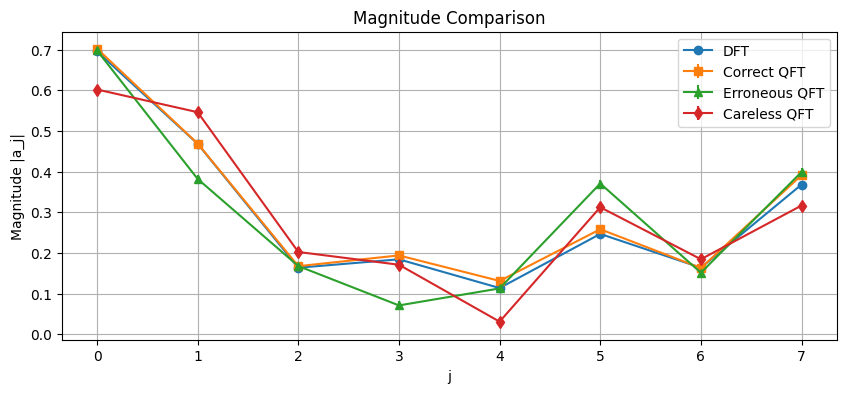

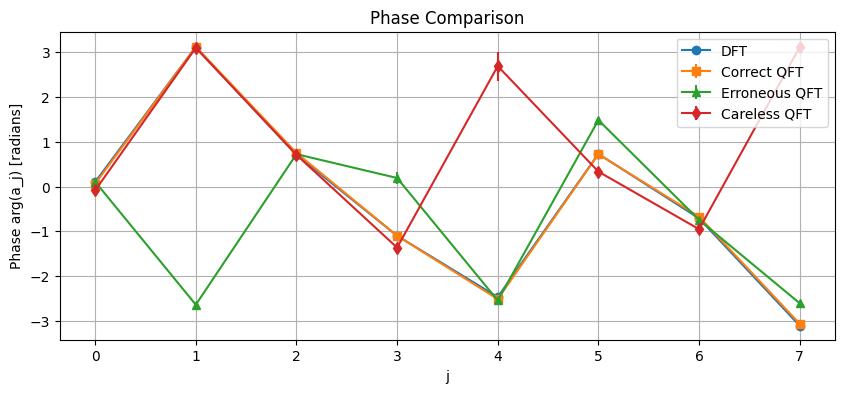

In [16]:
# Convert real + imag to magnitude and phase with error propagation
def compute_mag_phase(x, y, sigma_x, sigma_y):
    x = np.array(x)
    y = np.array(y)
    sigma_x = np.array(sigma_x)
    sigma_y = np.array(sigma_y)
    mag = np.sqrt(x**2 + y**2)
    phase = np.arctan2(y, x)
    # Propagate errors
    mag_err = np.sqrt((x*sigma_x)**2 + (y*sigma_y)**2) / mag
    phase_err = np.sqrt((x*sigma_y)**2 + (y*sigma_x)**2) / (x**2 + y**2)
    return mag, mag_err, phase, phase_err

# Correct QFT
mag_correct, mag_correct_err, phase_correct, phase_correct_err = compute_mag_phase(
    real_correct, imag_correct, real_correct_err, imag_correct_err
)
# Erroneous QFT
mag_error, mag_error_err, phase_error, phase_error_err = compute_mag_phase(
    real_error, imag_error, real_error_err, imag_error_err
)
# Careless QFT
mag_careless, mag_careless_err, phase_careless, phase_careless_err = compute_mag_phase(
    real_careless, imag_careless, real_careless_err, imag_careless_err
)
# DFT
mag_theory, _, phase_theory, _ = compute_mag_phase(real_theory, imag_theory, [0]*N, [0]*N)

x = np.arange(N)

# --- Plot Magnitude ---
plt.figure(figsize=(10,4))
plt.errorbar(x, mag_theory, yerr=None, fmt='o-', label="DFT")
plt.errorbar(x, mag_correct, yerr=mag_correct_err, fmt='s-', label="Correct QFT")
plt.errorbar(x, mag_error, yerr=mag_error_err, fmt='^-', label="Erroneous QFT")
plt.errorbar(x, mag_careless, yerr=mag_careless_err, fmt='d-', label="Careless QFT")
plt.xlabel("j")
plt.ylabel("Magnitude |a_j|")
plt.title("Magnitude Comparison")
plt.legend()
plt.grid(True)

# --- Plot Phase ---
plt.figure(figsize=(10,4))
plt.errorbar(x, phase_theory, yerr=None, fmt='o-', label="DFT")
plt.errorbar(x, phase_correct, yerr=phase_correct_err, fmt='s-', label="Correct QFT")
plt.errorbar(x, phase_error, yerr=phase_error_err, fmt='^-', label="Erroneous QFT")
plt.errorbar(x, phase_careless, yerr=phase_careless_err, fmt='d-', label="Careless QFT")
plt.xlabel("j")
plt.ylabel("Phase arg(a_j) [radians]")
plt.title("Phase Comparison")
plt.legend()
plt.grid(True)

plt.show()
